In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood,OnOffSVGPMC, OnOffSVGPPoiMC 
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

2022-09-23 02:12:54.150318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 02:12:54.267021: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-23 02:12:54.273013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 02:12:54.273026: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

In [3]:
Ytrain[(Xtrain<=2)] = 1.0
Ytrain[(Xtrain>2) & (Xtrain<3)] = 0.0
Ytrain[(Xtrain>3) & (Xtrain<3.5)] = 3.0
Ytrain[(Xtrain>3.5) & (Xtrain<4)] = 4.0
Ytrain[(Xtrain>=4)] = 5.0

Ytrain[(Xtrain>7) & (Xtrain<9)] = 0.0

Xtrain = Xtrain.astype(gpf.default_float())
Ytrain = Ytrain.astype(gpf.default_float())
y_poi = tfp.distributions.Poisson(rate=Ytrain,force_probs_to_zero_outside_support=True)
Ytrain=y_poi.sample().numpy()

In [4]:
Ytrain

array([[ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 3.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 3.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 3.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 4.],
       [ 2.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 1.],
       [ 0.],
      

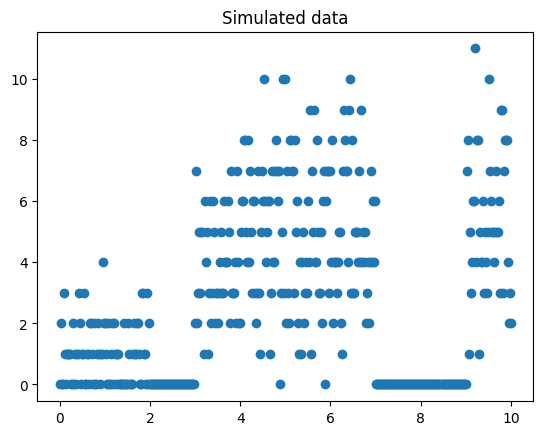

In [5]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [6]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [7]:
# model definition
m = OnOffSVGPPoiMC(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg, samples=100
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, False)

In [8]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [9]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
#logf = run_adam(m, 10)

In [10]:
%%time
logf = run_adam(m, 100000)

CPU times: user 12min 45s, sys: 21.1 s, total: 13min 6s
Wall time: 8min 2s


-636.4977

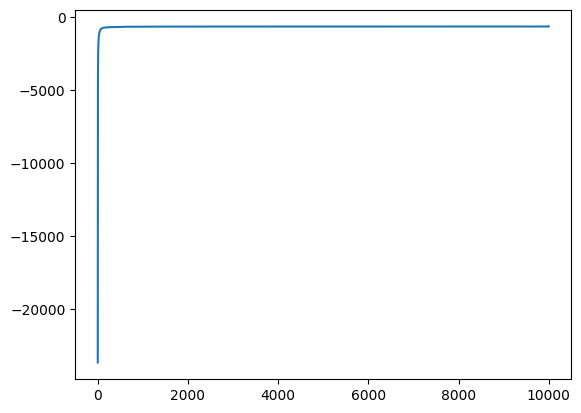

In [11]:
plt.plot(np.arange(len(logf)), logf)
logf[-1]

-643.2087

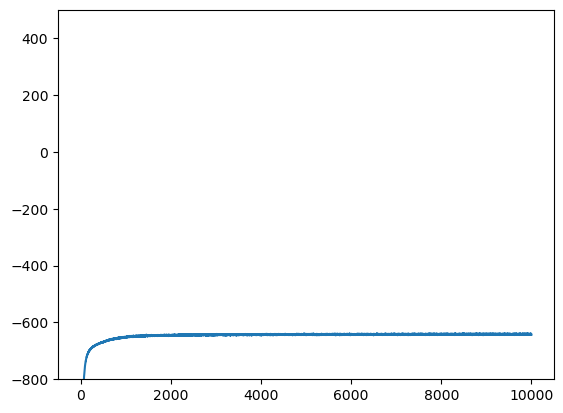

In [11]:
plt.plot(np.arange(len(logf)), logf)
plt.ylim((-800),500)
logf[-1]

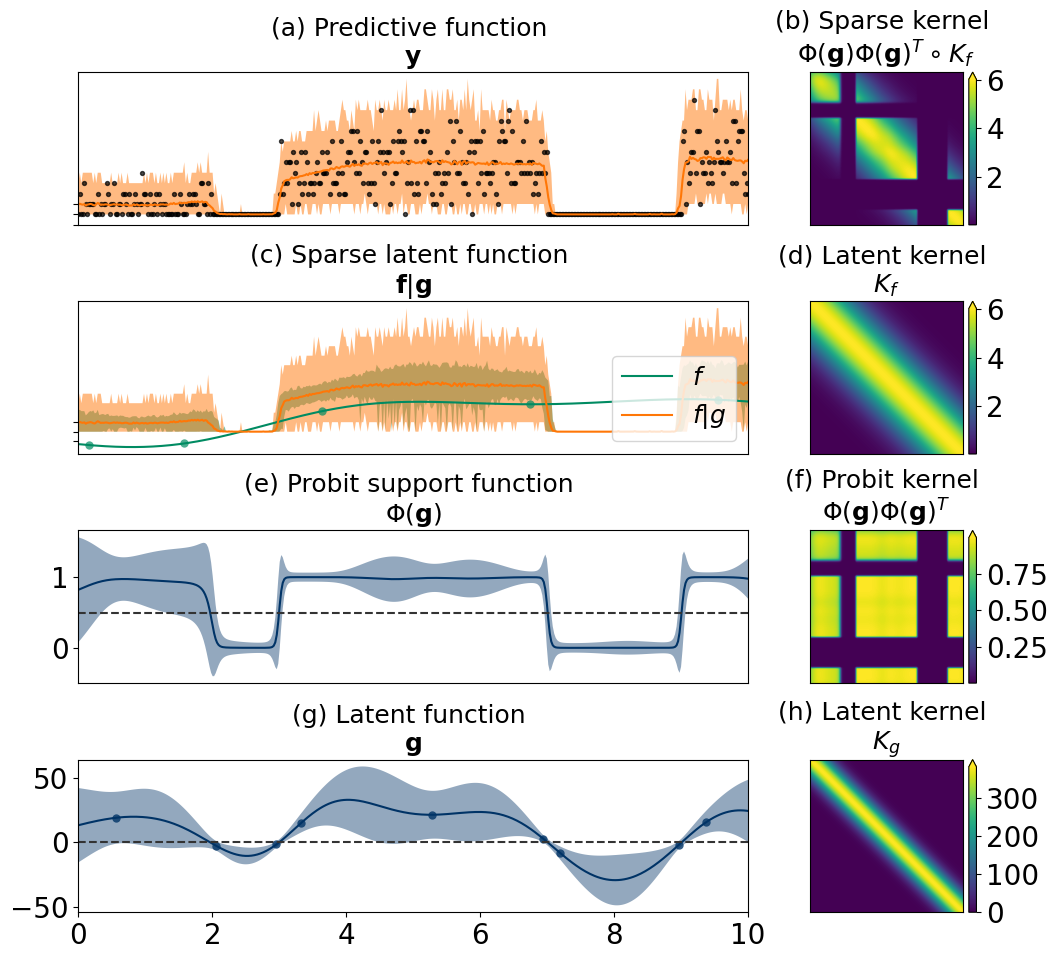

<Figure size 1100x1000 with 0 Axes>

In [15]:


PlotOnOff1D(m, softplus=True)
plt.savefig('appendix_figure.png')

In [13]:
# get prior KL
KL = m.build_prior_KL()

# get augmented functions
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(m.X)

data_shape = m.X.shape
u = tf.random.normal(shape=data_shape + (m.samples,))
w = tf.random.normal(shape=data_shape + (m.samples,))

# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u * g_std_NDS

In [14]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

phi_g_samples = normcdf(g_samples)

In [15]:
f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

In [16]:
shifted_softplus_f_samples = tf.math.softplus(f_samples+2)


y_poi = tfp.distributions.Poisson(rate=tf.math.softplus(shifted_softplus_f_samples),
                                  force_probs_to_zero_outside_support=True)


y_NDS = tf.expand_dims(m.Y, -1)
y_is_zero = tf.cast(y_NDS==0, tf.float32)
py_if_zero = (1-phi_g_samples) + phi_g_samples*y_poi.prob(y_NDS)
py_if_greater = phi_g_samples*y_poi.prob(y_NDS)
py = y_is_zero*py_if_zero + (1-y_is_zero)*py_if_greater

# mean over samples
py = tf.reduce_mean(py, -1)
# sum over data
py = tf.reduce_sum(tf.math.log(py))

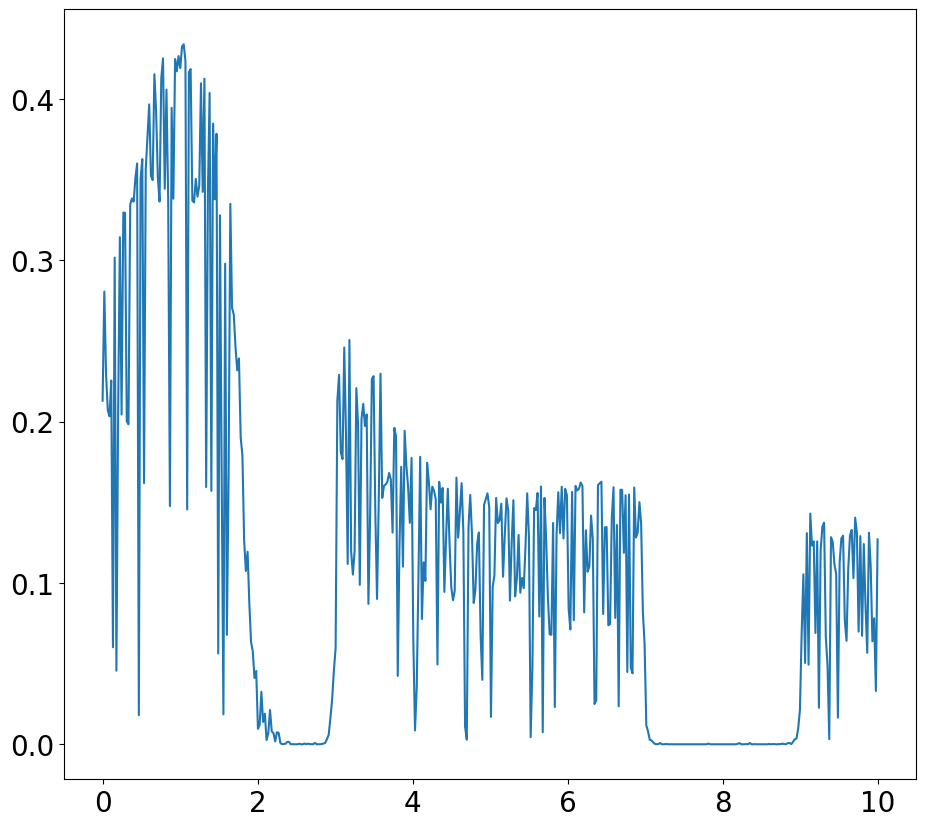

In [17]:
plt.plot(m.X, tf.reduce_mean(py_if_greater, -1))

In [18]:
plt(m.y)

AttributeError: 'OnOffSVGPPoiMC' object has no attribute 'y'

In [ ]:
m.trainable_variables

In [ ]:
Zg

In [19]:
_gfmean,_gfvar,_,_fmean,_fvar,_gmean,_gvar,_pgmean,_pgvar = m.predict_onoffgp(m.X)

In [ ]:
plt.plot(np.arange(len(_gfmean)),tf.math.softplus(_gfmean+2))

In [20]:
_gfmean

<tf.Tensor: shape=(450, 1), dtype=float32, numpy=
array([[-8.21252048e-01],
       [-9.02302563e-01],
       [-9.84317243e-01],
       [-1.06713343e+00],
       [-1.15058899e+00],
       [-1.23452449e+00],
       [-1.31878328e+00],
       [-1.40320909e+00],
       [-1.48765159e+00],
       [-1.57195866e+00],
       [-1.65598297e+00],
       [-1.73957956e+00],
       [-1.82260525e+00],
       [-1.90492046e+00],
       [-1.98638856e+00],
       [-2.06687546e+00],
       [-2.14625311e+00],
       [-2.22439361e+00],
       [-2.30117512e+00],
       [-2.37648058e+00],
       [-2.45019436e+00],
       [-2.52220726e+00],
       [-2.59241390e+00],
       [-2.66071224e+00],
       [-2.72700667e+00],
       [-2.79120159e+00],
       [-2.85320830e+00],
       [-2.91294217e+00],
       [-2.97032118e+00],
       [-3.02526903e+00],
       [-3.07770896e+00],
       [-3.12757301e+00],
       [-3.17479300e+00],
       [-3.21930838e+00],
       [-3.26105809e+00],
       [-3.29998541e+00],
       [-3.336

In [22]:
m.kernf

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float32,8.6853
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float32,0.942916
